In [1]:
!git clone https://github.com/openai/multiagent-particle-envs.git

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 242 (delta 0), reused 3 (delta 0), pack-reused 237
Receiving objects: 100% (242/242), 107.24 KiB | 17.87 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
cd multiagent-particle-envs

/content/multiagent-particle-envs


In [3]:
pip install -U .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/multiagent-particle-envs
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for multiagent: filename=multiagent-0.0.1-py3-none-any.whl size=27795 sha256=f8d98d3e153ed462bcd2a98d4ff2c5600ae7109558ef38cdca60c586f051d2b4
  Stored in directory: /root/.cache/pip/wheels/a5/3c/df/e74fd0fedbb25ec1700bb07798d9b2de38719f66bf560c0339
Successfully built multiagent


In [4]:
pip install gym==0.10.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 40.9 MB/s 
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581307 sha256=a6f59003181bd99a15124dc1184d7962a7345c829320b3d84d6487f88c18e95c
  Stored in directory: /root/.cache/pip/wheels/7a/2c/df/a05b548a40fae16ca400ecbeda0067e1a296499c1fbd7e0c9a
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import random
from make_env import make_env
env = make_env("simple_spread")
import matplotlib.pyplot as plt

In [7]:
class Buffer:
   def __init__(self):
     self.agent1_reward = []
     self.agent2_reward = []
     self.agent3_reward = []
     self.agent1_mean   = []
     self.agent2_mean   = []
     self.agent3_mean   = []
     self.episodes      = []

In [8]:
class Actor(nn.Module):
  def __init__(self,state_size,action_size):
    super(Actor,self).__init__()
    self.fc1 = nn.Linear(state_size,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,256)
    self.fc5 = nn.Linear(256,512)
    self.fc6 = nn.Linear(512,1024)
    self.fc7 = nn.Linear(1024,1024)
    self.fc8 = nn.Linear(1024,512)
    self.fc9 = nn.Linear(512,256)
    self.fc10 = nn.Linear(256,128)
    self.fc11 = nn.Linear(128,64)
    self.fc12 = nn.Linear(64,32)
    self.fc13 = nn.Linear(32,action_size)
  def forward(self,x):
    x = self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(self.fc2(f.relu(self.fc1(x)))))))))
    x = self.fc10(f.relu(self.fc9(f.relu(self.fc8(f.relu(self.fc7(f.relu(self.fc6(f.relu(x))))))))))
    x = f.relu(self.fc12(f.relu(self.fc11(f.relu(x)))))
    x = f.softmax(self.fc13(x))
    return x

In [9]:
class Critic(nn.Module):
  def __init__(self,state_size,action_size):
    super(Critic,self).__init__()
    self.fc1 = nn.Linear(state_size,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,256)
    self.fc5 = nn.Linear(256,512)
    self.fc6 = nn.Linear(512,1024)
    self.fc7 = nn.Linear(1024,1024)
    self.fc8 = nn.Linear(1024,512)
    self.fc9 = nn.Linear(512,256)
    self.fc10 = nn.Linear(256,128)
    self.fc11 = nn.Linear(128,64)
    self.fc12 = nn.Linear(64,32)
    self.fc13 = nn.Linear(32,1)
  def forward(self,x):
    x = self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(self.fc2(f.relu(self.fc1(x)))))))))
    x = self.fc10(f.relu(self.fc9(f.relu(self.fc8(f.relu(self.fc7(f.relu(self.fc6(f.relu(x))))))))))
    x = f.relu(self.fc12(f.relu(self.fc11(f.relu(x)))))
    x = f.relu(self.fc13(x))
    return x

In [10]:
class Agent:
  def __init__(self,state_size,action_size,i):
    self.state_size       = state_size
    self.action_size      = action_size
    self.gamma            = 0.99
    self.lamda            = 0.95
    self.device           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.actor            = Actor(self.state_size,self.action_size).to(self.device)
    self.target_actor     = Actor(self.state_size,self.action_size).to(self.device)
    self.critic           = Critic(self.state_size,self.action_size).to(self.device)
    self.target_critic    = Critic(self.state_size,self.action_size).to(self.device)
    self.actor_optim      = optim.Adam(self.actor.parameters() , lr = 3e-4)
    self.critic_optim     = optim.Adam(self.critic.parameters() , lr = 3e-4)
    self.actor_path       = "actor.pth"
    self.critic_path      = "critic.pth"
  def choose_action(self,state):
    rand                  = np.random.uniform(0.1,0.2,(1,5))[0]
    random_action         = torch.from_numpy(rand).float().to(self.device)
    action                = self.actor(state).to(self.device)
    actions               = action + random_action
    return actions.to(self.device)
  def get_gae(self,value,next_value,reward,mask):
    returns = []
    gae  = 0
    for i in range(5):
      delta = reward + mask *self.gamma * next_value -value
      gae   = delta + gae*self.lamda*mask
      returns.insert(0,gae + value + next_value)
      return returns
  def learn(self,state,next_state,reward,done):
    state                = torch.tensor(state,dtype = torch.float32).to(self.device)
    next_state           = torch.tensor(next_state , dtype = torch.float32).to(self.device)
    reward               = torch.tensor(reward,dtype = torch.float32).to(self.device)
    done                 = torch.tensor(done,dtype = torch.float32).to(self.device)
    action               = self.choose_action(state)
    log_prob             = torch.log(action).to(self.device)
    next_action          = self.choose_action(next_state)
    next_log_prob        = torch.log(next_action).to(self.device)
    value                = self.critic(state).to(self.device)
    next_value           = self.target_critic(next_state).to(self.device)
    r                    = self.get_gae(value,next_value,reward,done)
    returns              = torch.reshape(torch.tensor((r,r,r,r,r)),(1,5))[0].to(self.device)
    advantage            = returns - value[0]
    ratio                = (next_log_prob - log_prob).exp()
    s1                   = ratio* advantage
    s2                   = torch.clamp(ratio , 0.8,1.2)
    actor_loss           = torch.min(s1,s2).mean()
    critic_loss          = (advantage + next_value).pow(2).mean()
    loss                 = actor_loss + 0.5*critic_loss 
    torch.save(self.actor, self.actor_path)
    torch.save(self.critic, self.critic_path)
    self.actor_optim.zero_grad()
    self.critic_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    self.critic_optim.step()

In [46]:
buffer               = Buffer()
class mappo:
  def __init__(self,state_size,action_size,n_games,step):
    self.state_size           = state_size
    self.action_size          = action_size
    self.n_games              = n_games
    self.step                 = step
    self.device               = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.steps                = step
    self.agents               = [Agent(self.state_size,self.action_size,i) for i in range(env.n)]
  
  def choose_actions(self,state):
    actions = [] 
    for i in range(env.n):
      obs = torch.tensor(state[i],dtype = torch.float32).to(self.device)
      action = self.agents[i].choose_action(obs).to(self.device)
      actions.append(action)
    return actions
  def update(self,state,next_state,reward,done):
    for i in range(env.n):
      self.agents[i].learn(state[i],next_state[i],reward[i],done[i])
  def run(self):
    for i in range(self.n_games):
      state = env.reset()
      done = [False*3]
      score = [0*3]
      buffer.agent1_mean.append(np.mean(buffer.agent1_reward))
      buffer.agent2_mean.append(np.mean(buffer.agent2_reward))
      buffer.agent3_mean.append(np.mean(buffer.agent3_reward))
      buffer.episodes.append(i)
      #print("episode:",i,"[agent1:",buffer.agent1_mean[i],",agent2:",buffer.agent2_mean[i],"agent3:",buffer.agent3_mean[i],"]")
      for e in range(self.step):
        actions  = self.choose_actions(state)
        next_state ,reward,done,info = env.step(actions)
        if done:
          self.update(state,next_state,reward,done)
          state = next_state
          score += reward
          buffer.agent1_reward.append(reward[0])
          buffer.agent2_reward.append(reward[1])
          buffer.agent3_reward.append(reward[2])
          print(buffer.agent1_reward,buffer.agent2_reward)
        else:
          self.update(state,next_state,reward,done)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[-5.824418329221549, -5.824780092108686, -9.104936555214495, -9.127405648138605, -6.6566845593652335, -6.64897500447905, -5.99398495460401, -6.007842179053389, -11.267637035500378, -11.266121191114504, -9.642260724881794, -9.659207448428404, -11.542448896428022, -11.660697196946225, -8.828600920468828, -8.821101437358177, -8.279180768301526, -8.260061211349074, -6.83623208150922, -6.82712699674664, -6.701447848028161] [-5.824418329221549, -5.824780092108686, -9.104936555214495, -9.127405648138605, -6.6566845593652335, -6.64897500447905, -5.99398495460401, -6.007842179053389, -11.267637035500378, -11.266121191114504, -9.642260724881794, -9.659207448428404, -11.542448896428022, -11.660697196946225, -8.828600920468828, -8.821101437358177, -8.279180768301526, -8.260061211349074, -6.83623208150922, -6.82712699674664, -6.701447848028161]
[-5.824418329221549, -5.824780092108686, -9.104936555214495, -9.127405648138605, -6.6566845593652335, -6.64897500447905, -5.99398495460401, -6.0078421790533

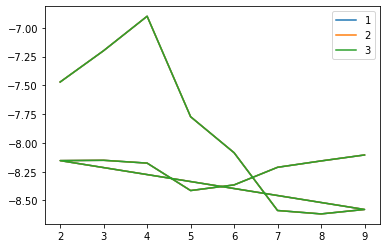

In [50]:
if __name__ =="__main__":
  ag = mappo(18,5,10,2)
  ag.run()
plot(buffer.episodes,buffer.agent1_mean,buffer.agent2_mean,buffer.agent3_mean)

In [48]:
def plot(pe,p1,p2,p3):
  plt.plot(pe,p1,label = "1")
  plt.plot(pe,p2,label = "2")
  plt.plot(pe,p3,label = "3")
  plt.legend()
  plt.show()

In [51]:
buffer.episodes

[2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9]